# Code
Letztlich ohne Z-Skalierung genutzt, weil kein Unterschied und die Sache leichter macht?

# Imports

In [27]:
import pandas as pd
from pathlib import Path
import numpy as np
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import anderson_ksamp
from sklearn.preprocessing import StandardScaler

# User Configuration

In [28]:
SAVE_FIG = True
SAVE_CSV = False

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

N_BOOTSTRAP = 1000 # 500-1000
SAMPLE_SIZE = 5000 # 5% of Sample size
RANDOM_SEED = 42
Z_SCALING = False

DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

## Load Data & Assign Correct Datatypes

In [29]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Own AD-Test Implementation

In [30]:
# ------------------------------------------------------------
# Anderson-Darling-Helfer (2-Stichproben)
# ------------------------------------------------------------
def anderson_darling_two_sample(arr1: np.ndarray,
                                arr2: np.ndarray,
                                *,
                                midrank: bool = True) -> tuple[float, float]:
    res = anderson_ksamp([arr1, arr2], midrank=midrank)
    return res.statistic, res.pvalue


# ------------------------------------------------------------
# Bootstrap-Funktion mit StandardScaler
# ------------------------------------------------------------
def bootstrap_anderson_darling_parallel(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    num_cols: list[str] | None = None,
    n_bootstrap: int = 1_000,
    n_sample_size: int | None = None,
    n_jobs: int = -1,
    random_state: int | None = None,
    z_scale: bool = False,
) -> pd.DataFrame:
    """
    Bootstrapped AD-Statistiken über numerische Features, optional mit StandardScaler.

    Parameters
    ----------
    df_real, df_synth : DataFrame
    num_cols : list[str] or None
        Zu testende numerische Spalten (None ⇒ gemeinsame numerische Spalten).
    n_bootstrap : int
    n_sample_size : int or None
    n_jobs : int
    random_state : int or None
    z_scale : bool
        Wenn True, werden alle Features mit StandardScaler (fit an df_real)
        standardisiert, bevor der Bootstrap startet.
    """
    # 1) Spalten bestimmen
    if num_cols is None:
        num_cols = (
            df_real.select_dtypes(include=[np.number])
                   .columns
                   .intersection(df_synth.columns)
                   .tolist()
        )

    # 2) Optional: StandardScaler an df_real fitten und transformieren
    if z_scale:
        scaler = StandardScaler()
        # Nur die num_cols
        real_vals = df_real[num_cols].to_numpy()
        synth_vals = df_synth[num_cols].to_numpy()
        # Fit nur auf Real, dann auf beide transformieren
        real_scaled = scaler.fit_transform(real_vals)
        synth_scaled = scaler.transform(synth_vals)
        # In DataFrames zurückwandeln für einfachen Zugriff
        df_real_scaled = pd.DataFrame(real_scaled, columns=num_cols, index=df_real.index)
        df_synth_scaled = pd.DataFrame(synth_scaled, columns=num_cols, index=df_synth.index)
    else:
        df_real_scaled = df_real[num_cols]
        df_synth_scaled = df_synth[num_cols]

    rng = np.random.default_rng(random_state)

    # 3) Eine Bootstrap-Iteration
    def one_iteration(seed: int) -> dict[str, float]:
        rs = np.random.default_rng(seed)
        stats: dict[str, float] = {}

        for col in num_cols:
            real = df_real_scaled[col].dropna().values
            synth = df_synth_scaled[col].dropna().values

            if len(real) < 2 or len(synth) < 2:
                stats[f"{col}_stat"] = np.nan
                stats[f"{col}_p"]    = np.nan
                continue

            n_r = len(real)  if n_sample_size is None else min(n_sample_size, len(real))
            n_s = len(synth) if n_sample_size is None else min(n_sample_size, len(synth))

            real_s  = rs.choice(real,  n_r, replace=True)
            synth_s = rs.choice(synth, n_s, replace=True)

            try:
                stat, p = anderson_darling_two_sample(real_s, synth_s)
            except Exception:
                stat, p = np.nan, np.nan

            stats[f"{col}_stat"] = stat
            stats[f"{col}_p"]    = p

        return stats

    # 4) Bootstrap parallel durchführen
    seeds = rng.integers(0, 2**32 - 1, size=n_bootstrap, dtype=np.uint64)
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(one_iteration)(s) for s in tqdm(seeds, desc="Bootstrap A-D")
    )

    return pd.DataFrame(results)


In [31]:
def plot_ci_stability(df_results: pd.DataFrame, feature_col: str, bootstrap_sizes: list = None, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots the stability of the 95% confidence interval of the AD Test Statistic
    for a given feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): AD Test Statistic (Bootstrap Iterations x Features)
        feature_col (str): Feature to visualize
        bootstrap_sizes (list, optional): List of bootstrap sample sizes to evaluate
    """
    if bootstrap_sizes is None:
        bootstrap_sizes = [10, 50, 100, 200, 500, 1000]
    
    ci_results = []
    for n in bootstrap_sizes:
        sample_stats = df_results[feature_col].iloc[:n]
        lower = np.percentile(sample_stats, 2.5)
        upper = np.percentile(sample_stats, 97.5)
        mean_stat = np.mean(sample_stats)
        
        ci_results.append({
            'n_bootstrap': n,
            'cs_stat_mean': mean_stat,
            'cs_stat_2_5': lower,
            'cs_stat_97_5': upper
        })
    
    df_ci_results = pd.DataFrame(ci_results)
    
    # Plot with seaborn
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.lineplot(data=df_ci_results, x='n_bootstrap', y='cs_stat_mean', marker='o', ax=ax, label='Mean AD Test Statistic', )
    
    # Confidence Interval fill (manual, asymmetric)
    ax.fill_between(df_ci_results['n_bootstrap'], 
                    df_ci_results['cs_stat_2_5'], 
                    df_ci_results['cs_stat_97_5'], 
                    alpha=0.3, label='95% Confidence Interval')
    
    ax.set_xlabel('Number of Bootstrap Iterations')
    ax.set_ylabel(f'AD Test Statistic ({feature_col})')
    ax.set_title(f'Stability of the 95% Confidence Interval of the AD Test Statistic ({feature_col}) with Increasing Bootstrap Size')
    ax.legend()
    # ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xscale('log')
    
    return fig, ax


In [32]:
def plot_featurewise_ci(df_results: pd.DataFrame, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots AD Test Statistic with 95% Confidence Intervals per Feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): Bootstrap results (Iterations x Features)
    """
    summary = []
    for col in df_results.columns:
        lower = np.percentile(df_results[col], 2.5)
        upper = np.percentile(df_results[col], 97.5)
        mean_stat = df_results[col].mean()
        
        summary.append({
            'feature': col,
            'cs_stat_mean': mean_stat,
            'cs_stat_2_5': lower,
            'cs_stat_97_5': upper
        })
    
    df_summary = pd.DataFrame(summary)
    
    # Fehlerbalken (hue-less)
    df_summary['err_low'] = df_summary['cs_stat_mean'] - df_summary['cs_stat_2_5']
    df_summary['err_high'] = df_summary['cs_stat_97_5'] - df_summary['cs_stat_mean']
    
    # Für seaborn -> barplot mit Custom CI (zwei Seiten unterschiedlich => Pointplot+manual errorbars)
    fig, ax = plt.subplots(figsize=figsize)

    sns.pointplot(
        data=df_summary,
        x='feature',
        y='cs_stat_mean',
        linestyle='none',
        capsize=0.2,
        color='steelblue',
        ax=ax
    )
    
    # Fehlerbalken manuell (weil asymmetrisch)
    for i, row in df_summary.iterrows():
        err_low = max(0, abs(row['err_low']))
        err_high = max(0, abs(row['err_high']))

        ax.errorbar(
            x=i, 
            y=row['cs_stat_mean'], 
            yerr=[[err_low], [err_high]], 
            fmt='none', 
            # ecolor='red', 
            elinewidth=1.5, 
            capsize=5
        )

    ax.set_xlabel('Feature')
    ax.set_ylabel('AD Test Statistic')
    ax.set_title('AD Test Statistic with 95% Confidence Intervals per Feature')
    plt.xticks(ticks=range(len(df_summary['feature'])), labels=df_summary['feature'], rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    return fig, ax


# Main Routine
## Daten Laden

In [33]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

In [34]:
num_attrs = df_real.select_dtypes(include=['number']).columns
cat_attrs = df_real.select_dtypes(exclude=['number']).columns

# Bootstrap

In [35]:
df_results = bootstrap_anderson_darling_parallel(df_real, df_synth, num_cols=num_attrs, n_bootstrap=N_BOOTSTRAP, n_sample_size=SAMPLE_SIZE, random_state=RANDOM_SEED, z_scale=Z_SCALING)

Bootstrap A-D:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap A-D: 100%|██████████| 1000/1000 [00:16<00:00, 59.54it/s]


In [36]:
# print(df_results.head())
df_plot = df_results.filter(like='_stat')
print(df_plot.head())

    age_stat  temperature_stat  heart_rate_stat  respiratory_rate_stat  \
0   9.216306         45.603703        63.957973              10.560260   
1  20.054432         37.130973        75.910724              19.127427   
2  26.318931         55.690638        73.429331              11.632318   
3  22.064857         60.639694        73.245032              11.982292   
4  21.782101         34.150806        75.650947              12.945038   

   oxygen_saturation_stat  systolic_bp_stat  diastolic_bp_stat  
0              185.956173         43.651919          23.155311  
1              170.305657         27.085283          17.036730  
2              184.030763         22.677108          21.580313  
3              120.774003         28.315467          12.166956  
4              151.801778         21.717663          19.102305  


In [37]:
suffix = f"_{N_BOOTSTRAP}_{SAMPLE_SIZE}"
suffix += "_zscale" if Z_SCALING else ""

if SAVE_CSV:
    df_plot.to_csv(OUTPUT_DIR_CSV / f"ad_bootstrap_{suffix}_results.csv", index=False, sep=";", decimal=",", encoding="utf-8")
    print(f"Bootstrap results saved to {OUTPUT_DIR_CSV / f'ad_bootstrap_{suffix}_results.csv'}")

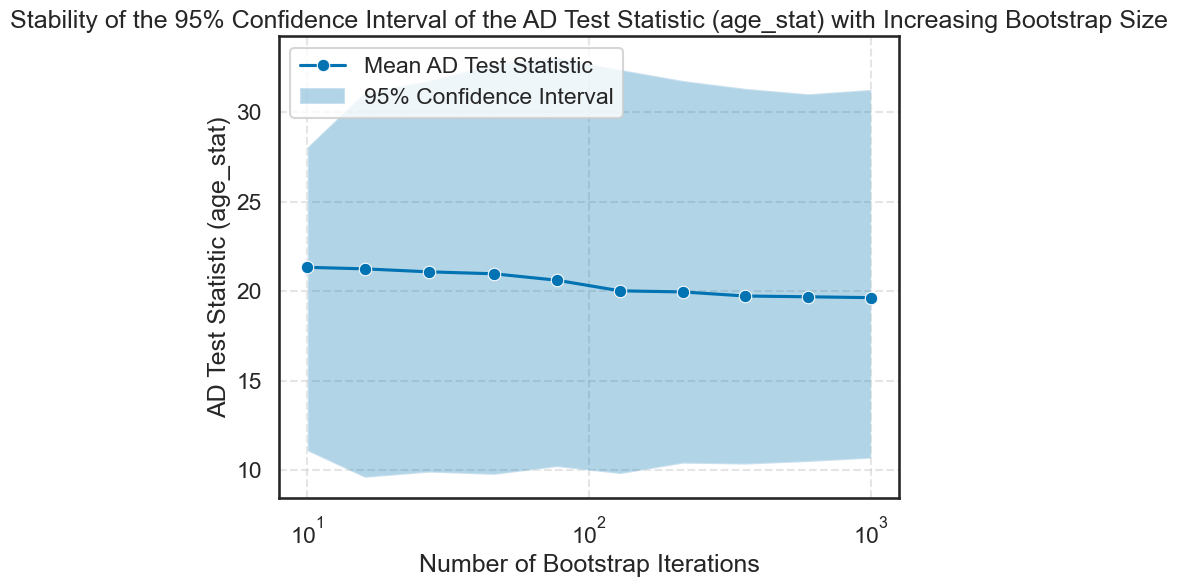

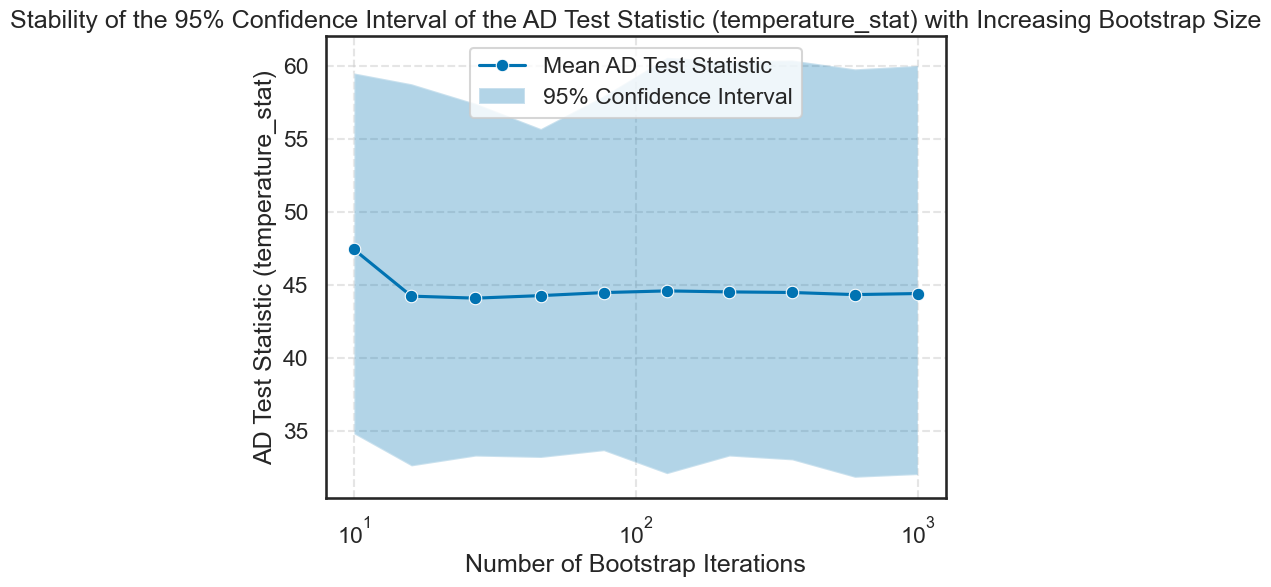

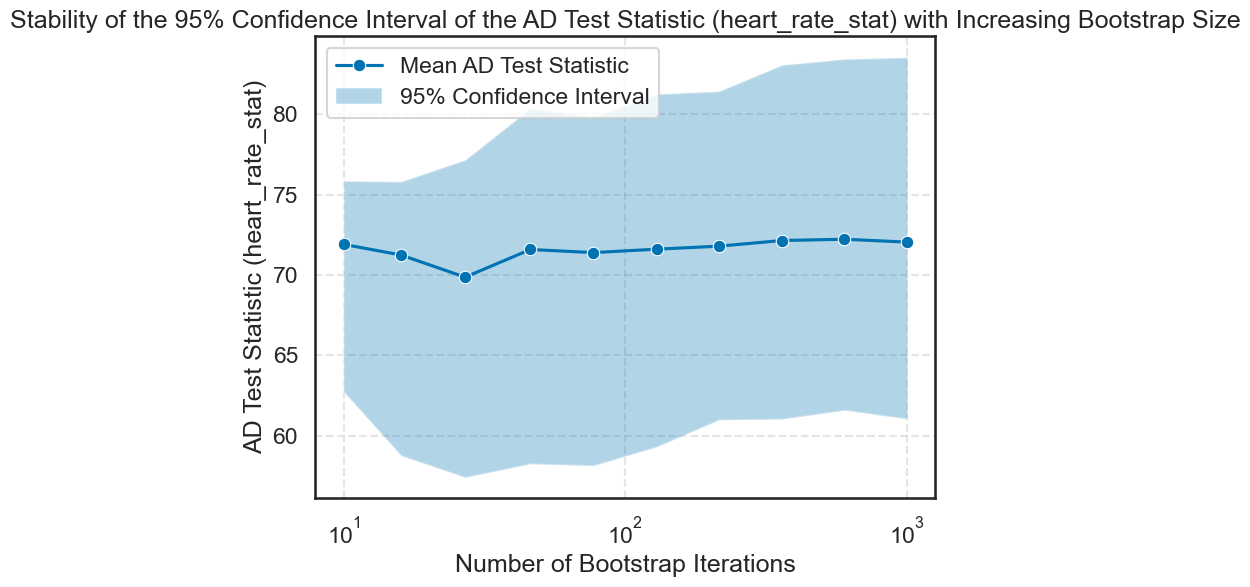

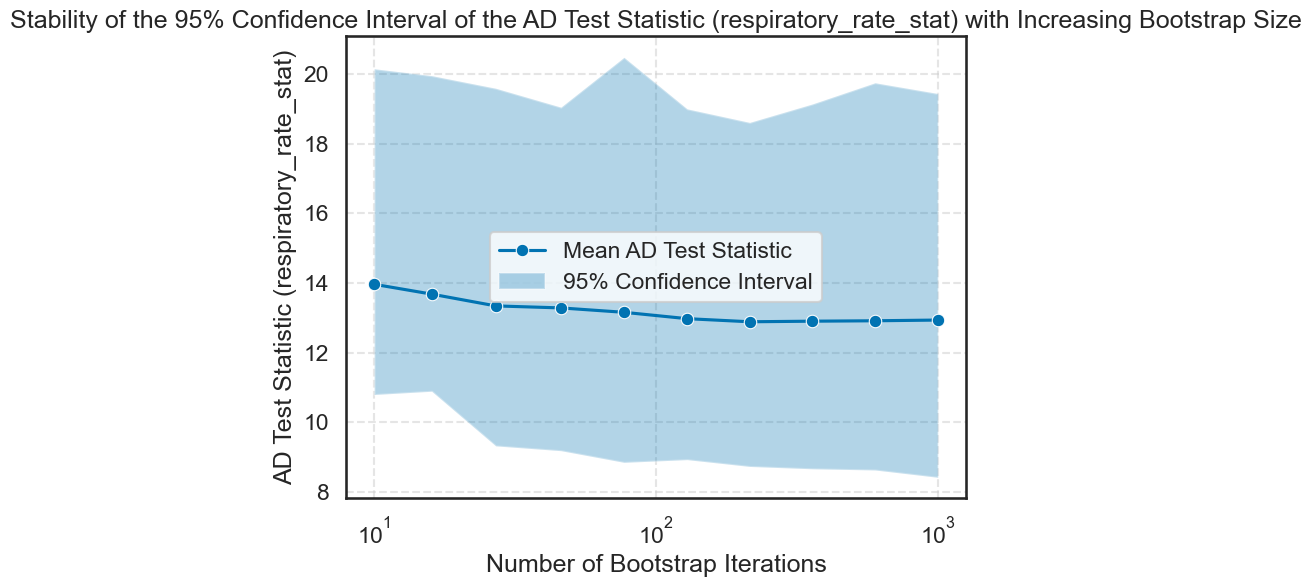

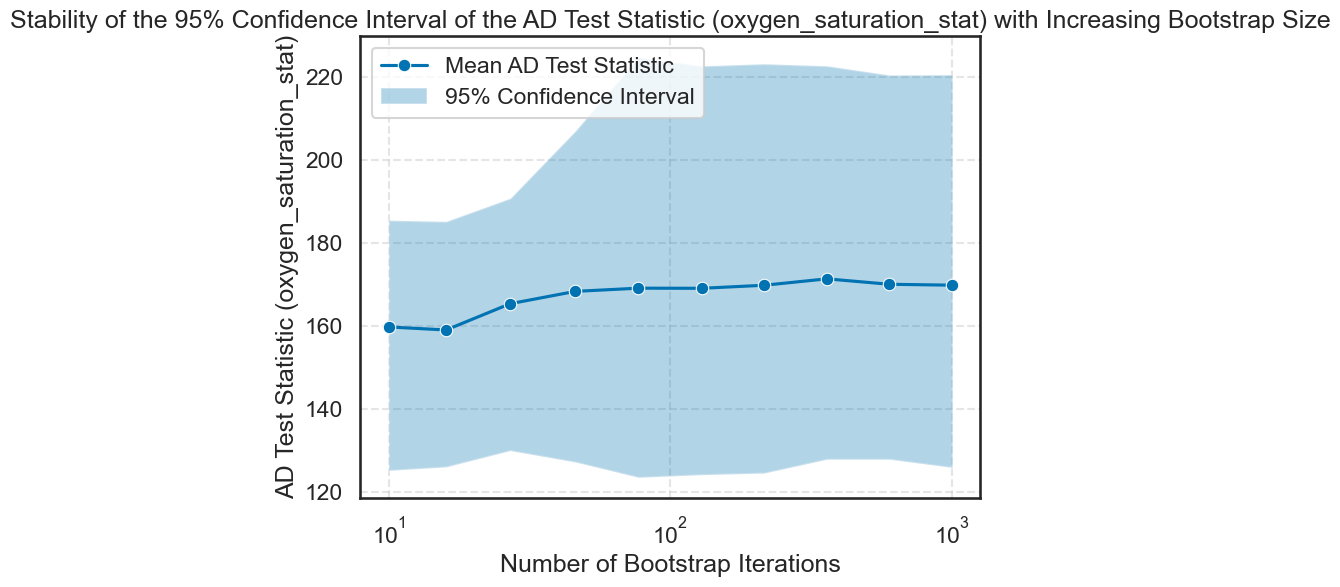

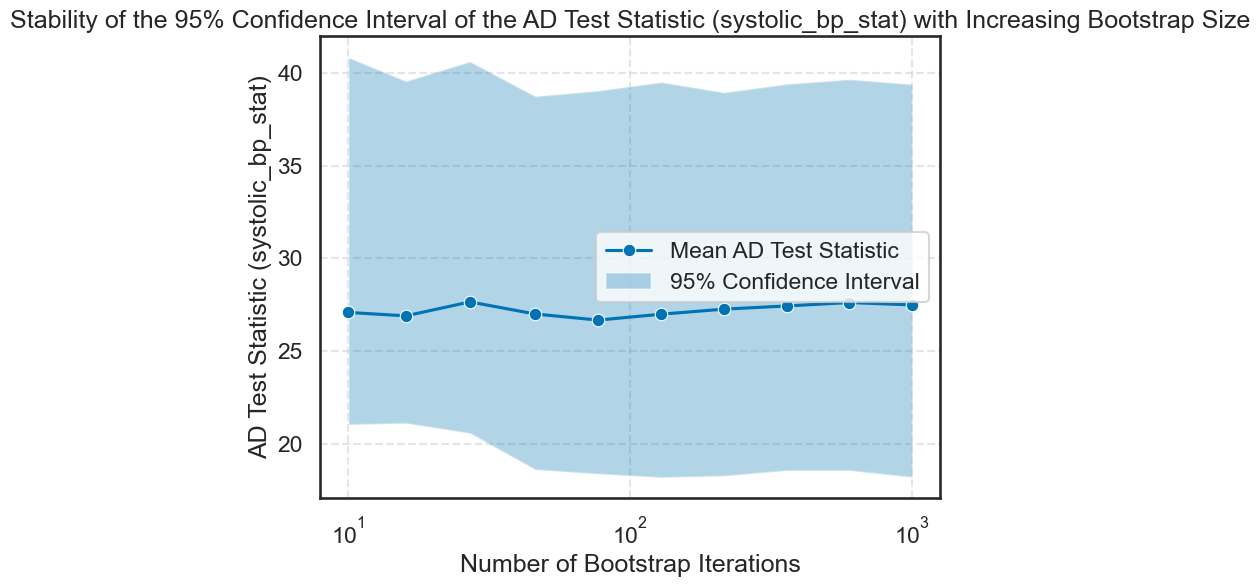

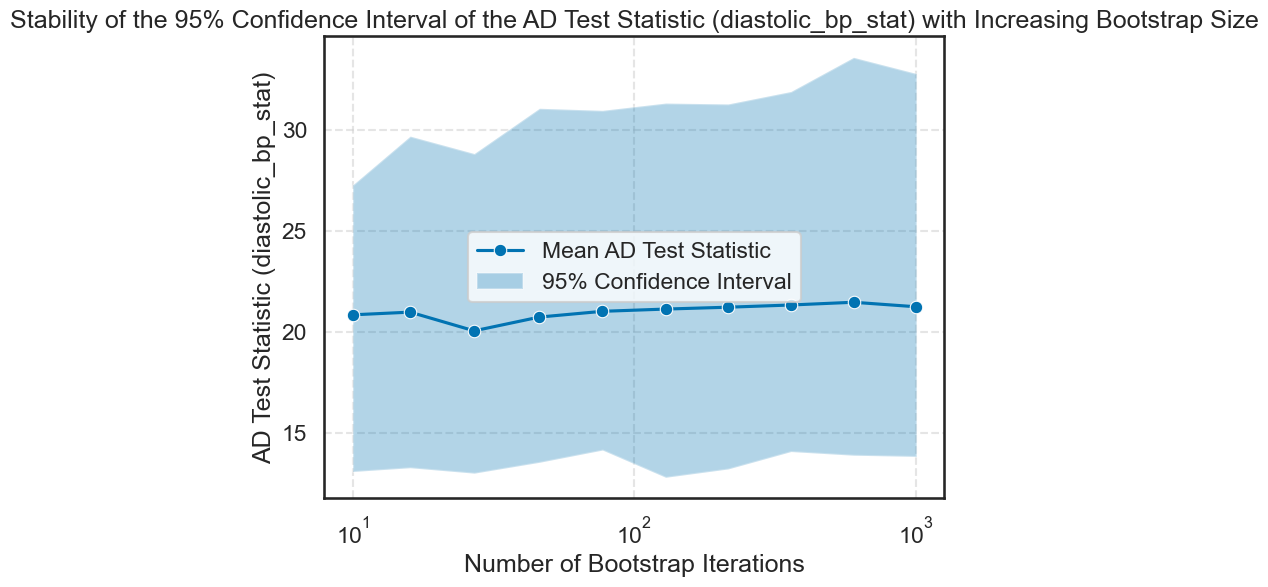

In [38]:
# bootstrap_sizes = np.linspace(10, N_BOOTSTRAP, N_STEPS, dtype=int).tolist()
bootstrap_sizes = np.unique(np.geomspace(10, N_BOOTSTRAP, num=10, dtype=int)).tolist()

# attr = "age"

for attr in df_real[num_attrs]:
    fig, ax = plot_ci_stability(df_results=df_plot, feature_col=f'{attr}_stat', bootstrap_sizes=bootstrap_sizes, figsize=(8, 6))
    plt.show()
    if SAVE_FIG:
        output_dir_ci = OUTPUT_DIR_FIG / "AD_CI-Sability"
        output_dir_ci.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_dir_ci / f"ad_ci_stability_{attr}_{suffix}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.close(fig)

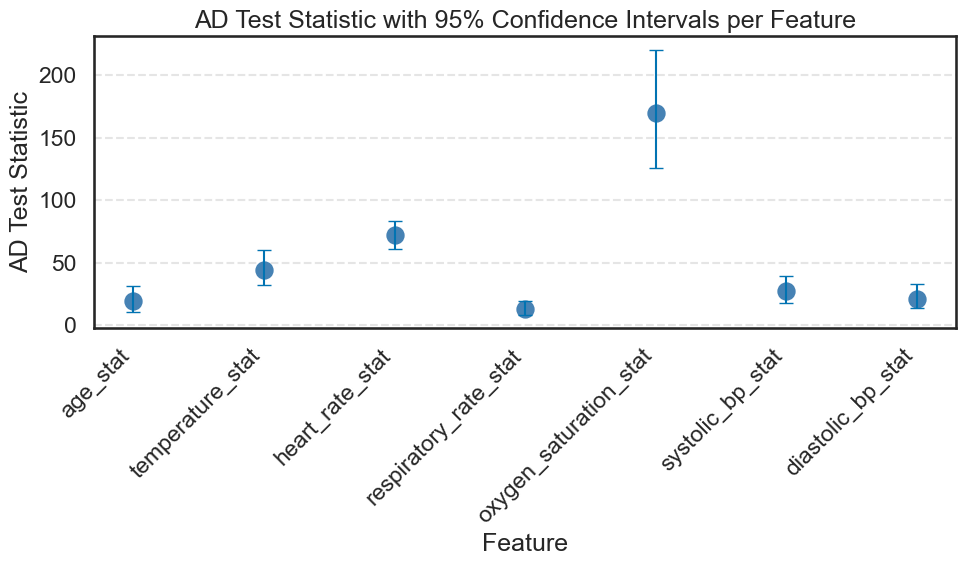

In [39]:
fig, ax = plot_featurewise_ci(df_plot, figsize=(10, 6))
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"ad_all_features_{suffix}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

# Interpretation der AD-Testergebnisse
Der Wert der Teststatistik T ist abhängig von der Sample Size. Bei 500 eher zwischen 0 und 20, bei 5000 eher zw. 0 und 200. Die Z-Skalierung hat, soweit ich das sehe, kein Einfluss.

T-Bereich (nach Z-Skalierung)	Interpretation (vereinfacht)
- 0–10	Sehr ähnliche Verteilungen
- 10–30	Kleine bis moderate Abweichungen
- 30–100	Deutliche Verteilungsunterschiede
- über 100	Extrem abweichend – vermutlich strukturelles Problem

🟥 Ihr Ausreißer-Feature Oxygen Saturation
- Deutlich andere Verteilung zwischen real & synthetisch.
- Großes CI = teils moderate, teils extreme Abweichungen in Bootstrap-Samples.
- Mögliche Ursachen: Skalierungsfehler, Ausreißer, Modellschwächen.
